In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [58]:
def extract_actor(row):
    all = str(row["Actor and line"]).split(":")
    actor = all[:1]
    line = ": ".join(all[1:])
    # print(actor, line)
    return actor[0], line

def split_episode_and_series(row):
    all = str(row["Episode_det"]).split(" ")
    serie = " ".join(all[:3])
    episode = " ".join(all[3:])
    return episode, serie

text = pd.read_csv("data/all_scripts.txt", header=None, delimiter=">")
text = text.rename(columns={0: "Actor and line", 1: "Scene", 2: "Episode_det"})
text[["Scene", "Episode_det"]] = text[["Scene", "Episode_det"]].ffill(axis=0)
text[["Episode", "Serie"]] = text.apply(lambda row: split_episode_and_series(row), axis=1, result_type="expand")
text = text.dropna(axis=0, subset=['Actor and line'])
text[["Actor", "Line"]] = text.apply(lambda row: extract_actor(row), axis=1, result_type="expand")
text = text.drop(["Actor and line", "Episode_det"], axis=1)
text[3000:]
print(len(text))

51292


In [59]:
# print(text[["Scene", "Serie"]].groupby("Serie").count())

In [60]:
text.groupby(["Serie", "Episode", "Scene"]).count().reset_index().groupby("Serie").count()[["Scene"]]

Scene
Serie            
 Series 01    157
 Series 02    205
 Series 03    193
 Series 04    219
 Series 05    198
 Series 06    211
 Series 07    208
 Series 08    192
 Series 09    177
 Series 10    190

**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [61]:
all_char = set(text['Actor'])
print(all_char)
char_mask = text[['Actor', 'Line']].groupby('Actor').count() >= 90
rec_char = set(char_mask[char_mask.values == True].index)
print(rec_char)
rec_char.discard('Man')
print(rec_char)

# lines_per_chars = lines.groupby("Character").count()[["Line"]]
# recurrent_chars = lines_per_chars[lines_per_chars["Line"] > 90]
# recurrent_chars

{'Vet', 'Stephen Hawking', 'Waitress', 'Marty', 'Guy', 'Woman', 'Ira', 'Nerdy guy', 'Beverly', 'Kripke', 'Zack', 'Second child', 'Steph', 'Girl', 'Howard’s Mother', 'Lalita', 'Arthur', 'Summer', 'Hot girl', 'Barber', 'Cleaner', 'Michaela', 'Scanner', 'Mass', 'Priya', 'Wyatt', 'Rebecca', 'Kevin', 'Beverley', 'Wil Wheaton', 'Joy', 'Dr Lorvis', 'Angela', 'Lakshmi', 'Mike M', 'Claire', 'Elon', 'Mrs Fowler', 'Phone rings. Answering machine', 'Director', 'Todd', 'Bill', 'Dennis', 'Elizabeth', 'George Takei', 'Page', 'Sheldon', 'Martha', 'Sheldon-bot', 'Randall', 'James', 'Nathan Fillion', 'Jimmy', 'Mrs Petrescu', 'Adam', 'Mrs Hofstadter', 'Receptionist', 'Jeff', 'Mike', 'Hernandez', 'Wil', 'Prof Sharpe', 'Third Floor Janitor', 'HR Woman', 'Santa', 'Eric', 'Bert', 'Helium Man', 'Man on TV', 'Actress', 'Stephen', 'Prof Laughlin', 'Seibert', 'Tattooist', 'Cosmonaut', 'Woman on TV', 'Siebert', 'Mrs. Rostenkowski', 'Dimitri', 'Meemaw', 'Together', 'Alicia', 'Leslie', 'Katee Sackhoff', 'Jesse', 'M

In [62]:
# print(f"Lines before : {len(text)}")
# text = text[text['Actor'].isin(rec_char)]
# print(f"Lines after : {len(text)}")

## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [63]:
# print(list(EXCLUDE_CHARS))
# text['Line'] = text['Line'].replace(list(EXCLUDE_CHARS), ' ') # should be iterated over
# text['Line'] = text.apply(lambda row: row['Line'].lower(), axis=1) # just apply lower to the Line col
# text[:5]
print(len(text))
def clean_line(line):
    for char in EXCLUDE_CHARS:
        line = line.replace(char, ' ')
    return line.lower()
text["Line"] = text["Line"].apply(clean_line)
text.head()

51292


Scene                     Episode       Serie  \
2   A corridor at a sperm bank.  Episode 01 – Pilot Episode   Series 01   
3   A corridor at a sperm bank.  Episode 01 – Pilot Episode   Series 01   
4   A corridor at a sperm bank.  Episode 01 – Pilot Episode   Series 01   
5   A corridor at a sperm bank.  Episode 01 – Pilot Episode   Series 01   
6   A corridor at a sperm bank.  Episode 01 – Pilot Episode   Series 01   

          Actor                                               Line  
2       Sheldon   so if a photon is directed through a plane wi...  
3       Leonard                         agreed  what s your point   
4       Sheldon   there s no point  i just think it s a good id...  
5       Leonard                                         excuse me   
6  Receptionist                                           hang on

**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

 so if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits  if it s unobserved it will  however  if it s observed after it s left the plane but before it hits its target  it will not have gone through both slits   agreed  what s your point   there s no point  i just think it s a good idea for a tee shirt   excuse me   hang on   one across is aegean  eight down is nabakov  twenty six across is mcm  fourteen down is… move your finger… phylum  which makes fourteen across port au prince  see  papa doc s capital idea  that s port au prince  haiti   can i help you   yes  um  is this the high iq sperm bank   if you have to ask  maybe you shouldn t be here   i think this is the place   fill these out   thank you  we ll be right back   oh  take your time  i ll just finish my crossword puzzle  oh wait   leonard  i don t think i can do this   what  are you kidding  you re a semi pro   no  we are committing genetic fraud  there s 

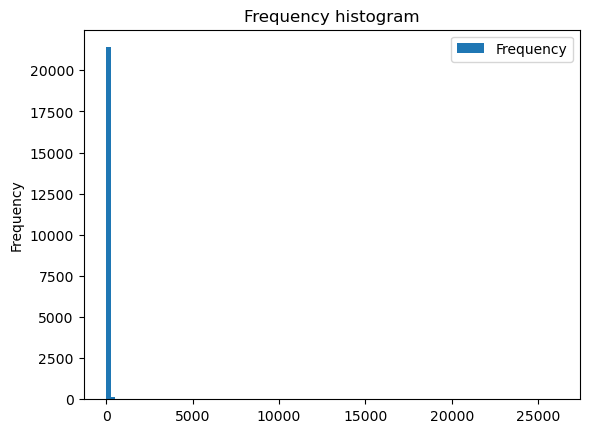

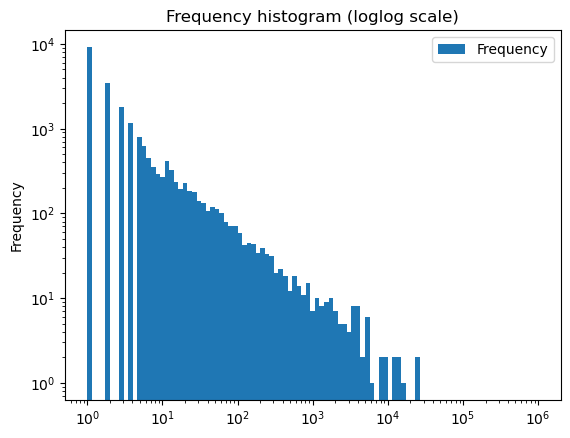

In [64]:
from collections import Counter
full_text = ' '.join(text['Line'])
print(full_text[:1000])
tokens = simple_tokeniser(full_text)
tokens_count = Counter(tokens)
print(tokens_count)
# print(tokens_count.keys())
# print(tokens_count.values())
# plt.bar(tokens_count.keys(), tokens_count.values())
# it's the zipf's law : stop words are so much more frequent than others
corpus_frequency = pd.DataFrame.from_dict(tokens_count, orient='index').reset_index()
corpus_frequency = corpus_frequency.rename(columns={'index': 'word', 0:'Frequency'})
corpus_frequency.plot.hist(column=["Frequency"], bins=100, title="Frequency histogram")
corpus_frequency.plot.hist(column=["Frequency"], loglog=True, bins=np.logspace(0, 6, 100),
                           title="Frequency histogram (loglog scale)");

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [65]:
talkative = {}
for char in rec_char:
    char_text = text[text['Actor'] == char]
    full_text_char = ' '.join(char_text['Line'])
    char_tokens = simple_tokeniser(full_text_char)
    talkative[char] = len(char_tokens)
    print(f"{char} is speaking {len(char_tokens)} words")

sorted_talkative = sorted(talkative.items(), key=lambda x:x[1])
print(sorted_talkative)

Howard is speaking 69505 words
Wil is speaking 1678 words
Kripke is speaking 1246 words
Zack is speaking 1427 words
Amy is speaking 39929 words
Arthur is speaking 1451 words
Bert is speaking 1146 words
Stuart is speaking 7955 words
Penny is speaking 79270 words
Priya is speaking 1940 words
Beverley is speaking 2029 words
Leslie is speaking 1249 words
Emily is speaking 1571 words
Mrs Wolowitz is speaking 1459 words
Sheldon is speaking 185381 words
Leonard is speaking 102496 words
Mrs Cooper is speaking 3389 words
Bernadette is speaking 27724 words
Raj is speaking 60099 words
[('Bert', 1146), ('Kripke', 1246), ('Leslie', 1249), ('Zack', 1427), ('Arthur', 1451), ('Mrs Wolowitz', 1459), ('Emily', 1571), ('Wil', 1678), ('Priya', 1940), ('Beverley', 2029), ('Mrs Cooper', 3389), ('Stuart', 7955), ('Bernadette', 27724), ('Amy', 39929), ('Raj', 60099), ('Howard', 69505), ('Penny', 79270), ('Leonard', 102496), ('Sheldon', 185381)]


## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [66]:
# your code goes here
text['Serie'].unique()
# print(text.columns)
text['mask'] = text.apply(lambda row: ((row['Serie'] == ' Series 09') or (row['Serie'] == ' Series 10')), axis=1) 
train_text = text[~text['mask']]
test_text = text[text['mask']]

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [67]:
# create a sheldon train df
# have a list of words said by shelton in train test
# have a list of all the words in train test
# do the difference between the two lists/sets
seldon_mask = train_text['Actor'] == 'Sheldon'
sheldon_text = train_text[seldon_mask]
others_text = train_text[~seldon_mask]
sheldon_all_tokens = simple_tokeniser(' '.join(sheldon_text['Line']))
others_all_tokens = simple_tokeniser(' '.join(others_text['Line']))
# print(sheldon_all_tokens)
sheldon_tokens = set(sheldon_all_tokens).difference(set(others_all_tokens))
print(sheldon_tokens)

def predict_the_actor(row):
    tokens = simple_tokeniser(row['Line'])
    for token in tokens: 
        if (token in sheldon_tokens):
            return 'Sheldon'
    return 'not Sheldon'

test_text.loc[:, "Actor_pred"] = test_text.apply(predict_the_actor, axis=1)
Y = test_text["Actor"]
Y_pred = test_text["Actor_pred"]
# Y, Y_pred
acc = metrics.accuracy_score(Y=='Sheldon', Y_pred=='Sheldon')
print(acc)

{'dodges', 'demeanour', 'linguistics', 'interaction', 'irish', 'lacks', 'continually', 'taboo', 'armenia', 'lanes', 'campus', 'pei', 'universality', 'plethora', 'teller', 'uncoordinated', 'defensive', 'jostling', 'pdfs', 'essential', 'untraceable', 'flecked', 'fertilized', '“a', 'fumes', 'eloy', 'sharpen', 'thou', 'workflow', 'kilometer', 'preface', 'authorities', 'expanding', 'stubble', 'entrusted', 'cluck', 'exploit', 'amazes', 'archaeological', 'wrecker', 'actively', '2005', 'biz', 'rewritten', 'hammering', 'pledge', 'noose', 'zazzy', 'organizee', 'unthinkable', 'ceti', 'optimistically', 'lecturer', 'beguiling', 'substantial', 'supergravity', 'footprint', 'ubuntu', 'julian', 'celebratory', 'argues', '1952', 'shook', 'leapt', 'flatware', 'collaboration', 'shaggy', '41', 'concentrating', 'grammatical', 'thorough', 'hypochondria', 'forer', 'saturated', 'hoist', 'gluttony', 'complimenting', 'kenobi', '1956', 'sawing', 'brain…', 'markers', 'fatality', 'hayn', 'instantly', 'grandchild', '

C:\Users\helli\AppData\Local\Temp\ipykernel_8420\719757192.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_text.loc[:, "Actor_pred"] = test_text.apply(predict_the_actor, axis=1)
